# Activity 7: Optimizing a deep learning model
In this activity we optimize our deep learning model. We aim to achieve greater performance than our model `bitcoin_lstm_v0`, which is off at about 6.8% from the real Bitcoin prices. We explore the following topics in this notebook:

* Experimenting with different layers and the number of nodes
* Grid search strategy for epoch and activation functions

## Load Data

In [1]:
"""Utility functions used in Activity 7."""

import random
import numpy as np

from matplotlib import pyplot as plt
from keras.callbacks import TensorBoard


def create_groups(data, group_size=7):
    """Create distinct groups from a continuous series.

    Parameters
    ----------
    data: np.array
        Series of continious observations.

    group_size: int, default 7
        Determines how large the groups are. That is,
        how many observations each group contains.

    Returns
    -------
    A Numpy array object.
    """
    samples = list()
    for i in range(0, len(data), group_size):
        sample = list(data[i:i + group_size])
        if len(sample) == group_size:
            samples.append(np.array(sample).reshape(1, group_size).tolist())

    a = np.array(samples)
    return a.reshape(1, a.shape[0], group_size)


def split_lstm_input(groups):
    """Split groups in a format expected by the LSTM layer.

    Parameters
    ----------
    groups: np.array
        Numpy array with the organized sequences.

    Returns
    -------
    X, Y: np.array
        Numpy arrays with the shapes required by
        the LSTM layer. X with (1, a - 1, b)
        and Y with (1, b). Where a is the total
        number of groups in `group` and b the
        number of observations per group.
    """
    X = groups[0:, :-1].reshape(1, groups.shape[1] - 1, groups.shape[2])
    Y = groups[0:, -1:][0]

    return X, Y


def mape(A, B):
    """Calculate the mean absolute percentage error from two series."""
    return np.mean(np.abs((A - B) / A)) * 100


def rmse(A, B):
    """Calculate the root mean square error from two series."""
    return np.sqrt(np.square(np.subtract(A, B)).mean())


def train_model(model, X, Y, epochs=100, version=0, run_number=0):
    """Shorthand function for training a new model.

    This function names each run of the model
    using the TensorBoard naming conventions.

    Parameters
    ----------
    model: Keras model instance
        Compiled Keras model.

    X, Y: np.array
        Series of observations to be used in
        the training process.

    version: int
        Version of the model to run.

    run_number: int
        The number of the run. Used in case
        the same model version is run again.
    """
    hash = random.getrandbits(128)
    hex_code = '%032x' % hash
    model_name = f'bitcoin_lstm_v{version}_run_{run_number}_{hex_code[:6]}'

    tensorboard = TensorBoard(log_dir=f'./logs/{model_name}')

    model_history = model.fit(
        x=X, y=Y,
        batch_size=1, epochs=epochs,
        callbacks=[tensorboard],
        shuffle=False)

    return model_history


def plot_two_series(A, B, variable, title):
    """Plot two series using the same `date` index.

    Parameters
    ----------
    A, B: pd.DataFrame
        Dataframe with a `date` key and a variable
        passed in the `variable` parameter. Parameter A
        represents the "Observed" series and B the "Predicted"
        series. These will be labelled respectivelly.

    variable: str
        Variable to use in plot.

    title: str
        Plot title.
    """
    plt.figure(figsize=(14, 4))
    plt.xlabel('Observed and predicted')

    ax1 = A.set_index('date')[variable].plot(
        color='#d35400', grid=True, label='Observed', title=title)

    ax2 = B.set_index('date')[variable].plot(
        color='grey', grid=True, label='Predicted')

    ax1.set_xlabel("Predicted Week")
    ax1.set_ylabel("Predicted Values")

    plt.legend()
    plt.show()


def denormalize(reference, series,
                normalized_variable='close_point_relative_normalization',
                denormalized_variable='close'):
    """Denormalize the values for a given series.

    Parameters
    ----------
    reference: pd.DataFrame
        DataFrame to use as reference. This dataframe
        contains both a week index and the USD price
        reference that we are interested on.

    series: pd.DataFrame
        DataFrame with the predicted series. The
        DataFrame must have the same columns as the
        `reference` dataset.

    normalized_variable: str, default 'close_point_relative_normalization'
        Variable to use in normalization.

    denormalized_variable: str, default `close`
        Variable to use in de-normalization.

    Returns
    -------
    A modified DataFrame with the new variable provided
    in `denormalized_variable` parameter.
    """
    week_values = reference[reference['iso_week'] == series['iso_week'].values[0]]
    last_value = week_values[denormalized_variable].values[0]
    series[denormalized_variable] = last_value * (series[normalized_variable] + 1)

    return series


In [2]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from datetime import datetime, timedelta
from keras.models import load_model, Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, ActivityRegularization
from keras.callbacks import TensorBoard

#from scripts.utilities_activity7 import (
#    create_groups, split_lstm_input, 
#    train_model, plot_two_series, rmse, 
#    mape, denormalize)

np.random.seed(0)

Autosaving every 5 seconds


In [3]:
#  Load datasets
train = pd.read_csv('train_dataset1.csv')
test = pd.read_csv('test_dataset.csv')

In [4]:
#  Convert `date` column to datetime type
test['date'] = test['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [5]:
#  Group data into groups containing seven observations
train_data = create_groups(
    train['close_point_relative_normalization'][2:].values)
test_data = create_groups(
    test['close_point_relative_normalization'][:-3].values)

In [6]:
#  Reshape the data in the format expected by the LSTM layer
X_train, Y_train = split_lstm_input(train_data)

## Reference Model

In [8]:
#  Load data for `v0` of our model.
#  Call this `model_v0`.
model_v0 = load_model('bitcoin_lstm_v0.h5')

In [9]:
%%time

#  Train the reference model `model_v0`.
train_model(model=model_v0,
            X=X_train,Y=Y_train,
            epochs=100,
            version=0,run_number=0
            )

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 9.8085e-04
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 8.7883e-04
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 7.8717e-04
Epoch 12/100
1/1 [==============================] - 0s 6

## Adding Layers and Nodes

In [10]:
#  Initialize variables
period_length = 7
number_of_periods = 76
batch_size = 1

In [11]:
#  Model 1: two LSTM layers
model_v1 = Sequential()

model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))   # note return_sequences is now true

#  Add new LSTM layer to this network here.
#
model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size,number_of_periods,period_length),
    input_shape=(number_of_periods,period_length),
    return_sequences=False,stateful=False))

model_v1.add(Dense(units=period_length))
model_v1.add(Activation("linear"))

model_v1.compile(loss="mse", optimizer="rmsprop")

In [12]:
%%time
train_model(model=model_v1, X=X_train, Y=Y_train, epochs=100, version=1, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 9.1108e-04
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 7.7336e-04
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 6.6664e-04
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 5.8036e-04
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 5.0798e-04
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 4.4562e-04
Epoch 13/100
1/1 [===================

## Epochs

In [13]:
# Model 2: two LSTM layers, trained for 300 epochs
model_v2 = Sequential()

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v2.add(Dense(units=period_length))
model_v2.add(Activation("linear"))

model_v2.compile(loss="mse", optimizer="rmsprop")

In [14]:
%%time

#  Change the number of epochs below
#  to 300 and evaluate the results on TensorBoard.
#
train_model(model=model_v2, X=X_train, Y=Y_train, epochs=300, version=2, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 3/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 4/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 5/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 9.2273e-04
Epoch 9/300
1/1 [==============================] - 0s 5ms/step - loss: 8.1217e-04
Epoch 10/300
1/1 [==============================] - 0s 5ms/step - loss: 7.1432e-04
Epoch 11/300
1/1 [==============================] - 0s 3ms/step - loss: 6.2729e-04
Epoch 12/300
1/1 [==============================] - 0s 2ms/step - loss: 5.4956e-04
Epoch 13/300
1/1 [=======================

## Activation Functions

In [15]:
# Model 3: two LSTM layers, trained for 300 epochs,
#          tanh activation function
model_v3 = Sequential()

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v3.add(Dense(units=period_length))

#  Change the activation function
#  from "linear" to "tanh".
#
model_v3.add(Activation("tanh"))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [16]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=300, version=3, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4/300
1/1 [==============================] - 0s 3ms/step - loss: 8.9939e-04
Epoch 5/300
1/1 [==============================] - 0s 2ms/step - loss: 7.3259e-04
Epoch 6/300
1/1 [==============================] - 0s 3ms/step - loss: 6.0848e-04
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 5.1142e-04
Epoch 8/300
1/1 [==============================] - 0s 3ms/step - loss: 4.3321e-04
Epoch 9/300
1/1 [==============================] - 0s 3ms/step - loss: 3.6906e-04
Epoch 10/300
1/1 [==============================] - 0s 3ms/step - loss: 3.1581e-04
Epoch 11/300
1/1 [==============================] - 0s 3ms/step - loss: 2.7123e-04
Epoch 12/300
1/1 [==============================] - 0s 2ms/step - loss: 2.3363e-04
Epoch 13/300
1/1 [=======

## Regularization Strategies

In [17]:
model_v4 = Sequential()
model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#  Implement a Dropout() here.
#
model_v4.add(Dropout(0.2))

model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

#  TASK:
#  Implement a Dropout() here too.
#
model_v4.add(Dropout(0.2))

model_v4.add(Dense(units=period_length))
model_v4.add(Activation("tanh"))

model_v4.compile(loss="mse", optimizer="rmsprop")

In [18]:
%%time
train_model(model=model_v4, X=X_train, Y=Y_train, epochs=600, version=4, run_number=0)

Epoch 1/600
1/1 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 2/600
1/1 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 3/600
1/1 [==============================] - 0s 5ms/step - loss: 8.7272e-04
Epoch 4/600
1/1 [==============================] - 0s 3ms/step - loss: 6.6995e-04
Epoch 5/600
1/1 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 6/600
1/1 [==============================] - 0s 2ms/step - loss: 4.4310e-04
Epoch 7/600
1/1 [==============================] - 0s 3ms/step - loss: 4.4466e-04
Epoch 8/600
1/1 [==============================] - 0s 5ms/step - loss: 3.9275e-04
Epoch 9/600
1/1 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 10/600
1/1 [==============================] - 0s 2ms/step - loss: 4.1069e-04
Epoch 11/600
1/1 [==============================] - 0s 2ms/step - loss: 6.1090e-04
Epoch 12/600
1/1 [==============================] - 0s 2ms/step - loss: 4.1975e-04
Epoch 13/600
1/1 [===========

## Evaluate Models

In [19]:
combined_set = np.concatenate((train_data, test_data), axis=1)

def evaluate_model(model, kind='series'):
    """Compute the MSE for all future weeks in period.
    
    Parameters
    ----------
    model: Keras trained model
    
    kind: str, default 'series'
        Kind of evaluation to perform. If 'series', 
        then the model will perform an evaluation 
        over the complete series.
    
    Returns
    -------
    evaluated_weeks: list
        List of MSE values for each evaluated
        test week.
    """
    if kind == 'series':
        predicted_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+76]
            predicted_weeks.append(model.predict(input_series))

        predicted_days = []
        for week in predicted_weeks:
            predicted_days += list(week[0])

        return predicted_days
    else:
        evaluated_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+77]

            X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
            Y_test = input_series[0:,-1:][0]

            result = model.evaluate(x=X_test, y=Y_test, verbose=0)
            evaluated_weeks.append(result)
            
            return evaluated_weeks


In [20]:
def plot_weekly_mse(series, model_name, color):
    """Plot weekly MSE."""
    ax = pd.Series(series).plot(drawstyle="steps-post",
                                figsize=(14,4),
                                color=color,
                                grid=True,
                                label=model_name,
                                alpha=0.7,
                                title='Mean Squared Error (MSE) for Test Data (all models)'.format(
                                       model_name))

    ax.set_xticks(range(0, len(series)))
    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("MSE")

    return ax

In [21]:
def plot_weekly_predictions(predicted_days, name, display_plot=True, 
                            variable='close'):
    """Plot weekly predictions and calculate RMSE and MAPE."""
    
    # Create dataframe to store predictions and associated dates
    last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
    list_of_days = []
    for days in range(1, len(predicted_days) + 1):
        D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
        list_of_days.append(D)
    
    predicted = pd.DataFrame({
        'date': list_of_days,
        'close_point_relative_normalization': predicted_days
    })
    
    # Convert `date` variable to datetime
    predicted['date'] = predicted['date'].apply(
        lambda x: datetime.strptime(x, '%Y-%m-%d'))

    # Create iso_week column in `predicted` dataframe
    predicted['iso_week'] = predicted['date'].apply(
        lambda x: x.strftime('%Y-%U'))

    # Denormalize predictions
    predicted_close = predicted.groupby('iso_week').apply(
        lambda x: denormalize(test[:-3], x))

    # Plot denormalized predictions and observed values
    plot_two_series(test[:-3], predicted_close,
                    variable=variable,
                    title=f'{name}: Predictions per Week')
    
    # Calculate RMSE and MAPE
    print(f'RMSE: {rmse(test[:-3][variable], predicted_close[variable]):.2f}')
    print(f'MAPE: {mape(test[:-3][variable], predicted_close[variable]):.2f}%')

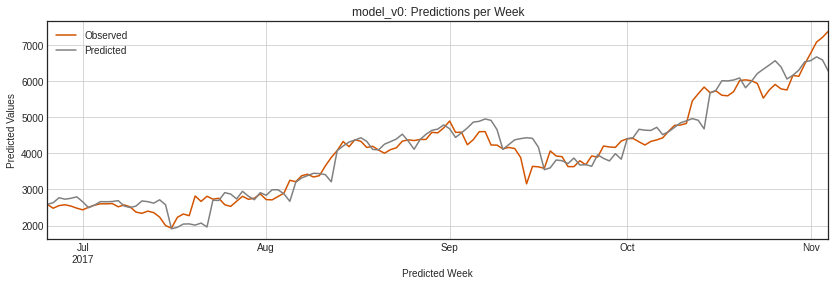

RMSE: 357.80
MAPE: 6.67%


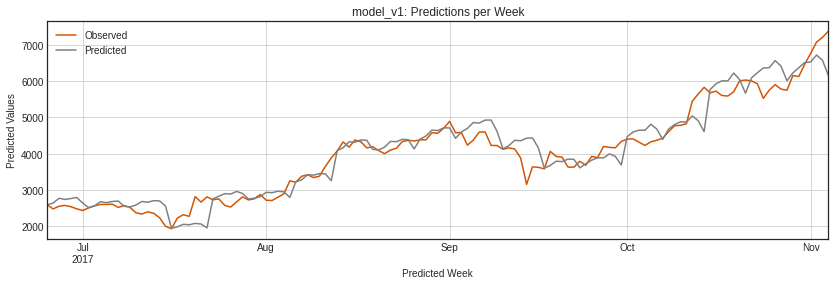

RMSE: 362.22
MAPE: 6.74%


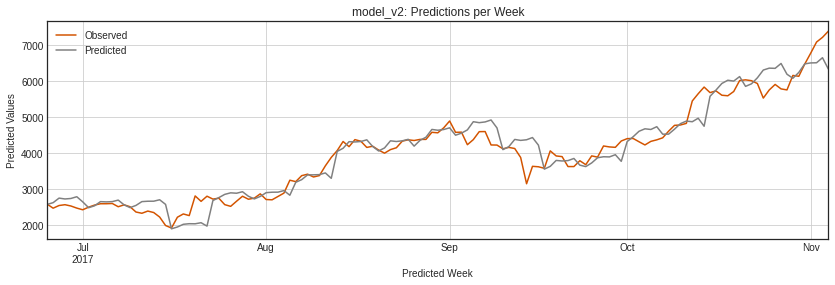

RMSE: 345.54
MAPE: 6.48%


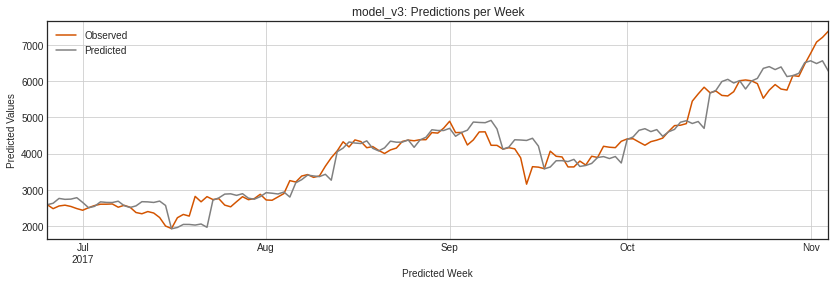

RMSE: 350.40
MAPE: 6.36%


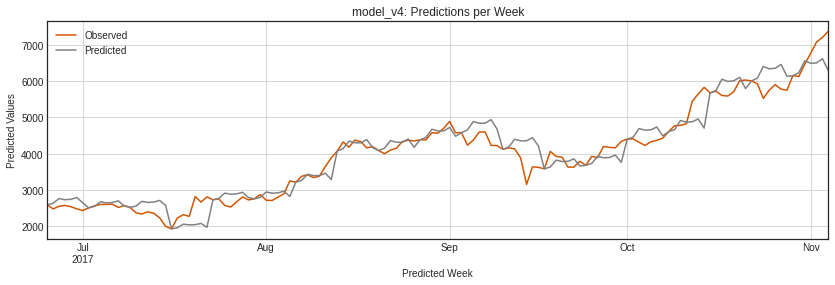

RMSE: 351.24
MAPE: 6.46%


In [22]:
#  Evaluate each model trained in this activity in sequence
models = [model_v0, model_v1, model_v2, model_v3, model_v4]
for i, M in enumerate(models):
    predicted_days = evaluate_model(M, kind='series')
    plot_weekly_predictions(predicted_days, f'model_v{i}')